# Final Project on Supervised Learning

### LAN and WAN Response Analysis 
- Description: The source of our data comes from the variablity of a LAN network when it is connecting to the Internet. The data is collected by the ping response time from the devices of the local internet router and to the first-hop server on the internet.
- Group Members: Eric Topmiller, Viphu Nguyen, David Gigremosa, Paul Rozario

Question to Answer: What is the worst time of day for ping response with ethernet and wireless for both LAN and WAN?

In [88]:

# Import libraries
import sys
# sys.path.append('C:\\Users\\mgwyn_dgsghje\\AppData\\Roaming\\Python\\Python38\\Scripts')
# !pip install numpy --user --upgrade --ignore-installed
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style

In [89]:
# Set the dataset from the network csv
df = pd.read_csv('ping_data_rp829c7e0e_eth.csv')
df.head()
df.sort_values('timestamp', inplace=True)

### Data Wrangling and Filtering the Data
- Done by Viphu Nguyen and Eric Topmiller

In [90]:
# Finding the missing values from the ping dataset
df.isna().sum()

timestamp      0
location       0
source         0
local_dest     0
local_avg      0
remote_dest    0
remote_avg     0
dtype: int64

In [91]:
# Duplicate the dataframe in case of crashes
df1 = df.copy()

In [92]:
# Removing unncessary columns from the ping dataset
df1 = df1.drop(['location', 'local_dest', 'remote_dest'], axis = 1)
df1

,timestamp,source,local_avg,remote_avg
0,1.559041e+09,ethernet,0.19,8.14
1,1.559041e+09,ethernet,0.15,7.75
2,1.559041e+09,ethernet,0.15,8.68
3,1.559041e+09,ethernet,0.15,8.08
4,1.559041e+09,ethernet,0.15,8.20
...,...,...,...,...
69740,1.559691e+09,ethernet,0.15,8.70
69741,1.559691e+09,ethernet,0.15,8.43
69742,1.559691e+09,ethernet,0.15,8.71
69743,1.559691e+09,ethernet,0.15,8.42


#### *Each header definition*
- Timestamp: The current time of an event that is recorded
- Source: Network Source
- Local_avg: Response Time for local network (ms)
- Remote_avg: Response time for remote network (ms)

In [93]:
# create a column that is the start of the range of hours of the day, show the head, show it has all 24 hours of the day
#df1['hour'] = (df['timestamp'].astype(int) % 86400) / 14400
df1['hour'] = (df['timestamp'].astype(int) % 86400) / 28800
df1['hour'] = df1['hour'].astype(int)
print(df1.head())
print(df1['hour'].unique())
print(df1.info())

      timestamp    source  local_avg  remote_avg  hour
0  1.559041e+09  ethernet       0.19        8.14     1
1  1.559041e+09  ethernet       0.15        7.75     1
2  1.559041e+09  ethernet       0.15        8.68     1
3  1.559041e+09  ethernet       0.15        8.08     1
4  1.559041e+09  ethernet       0.15        8.20     1
[1 2 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69745 entries, 0 to 69744
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   69745 non-null  float64
 1   source      69745 non-null  object 
 2   local_avg   69745 non-null  float64
 3   remote_avg  69745 non-null  float64
 4   hour        69745 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 2.9+ MB
None


count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64
count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64


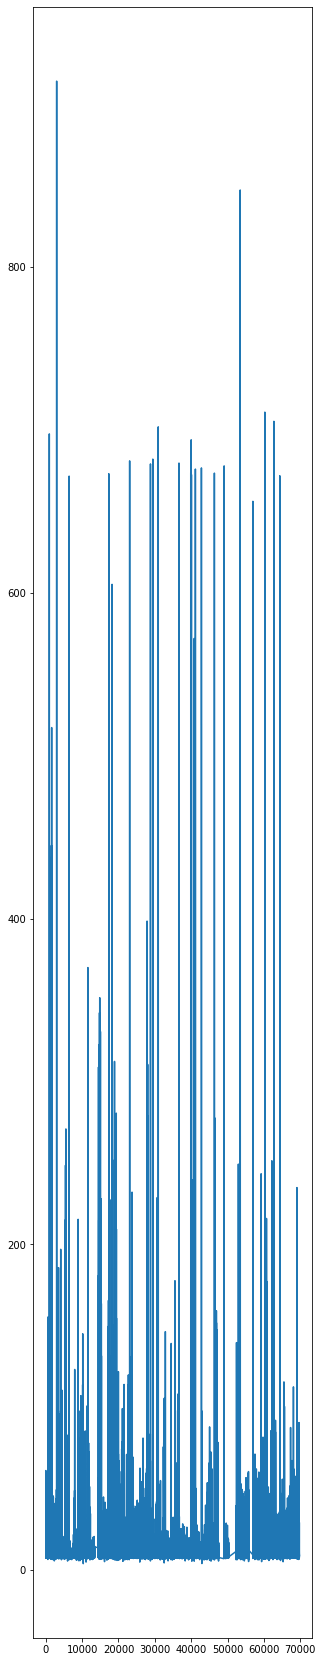

In [94]:
# remove the rows with avg of 9999.9999 since they are failures and will skew the data
#df1 = df1[(df1['local_avg'] != 9999) & (df1['remote_avg'] < 1000.0)]
df1 = df1.reset_index()
print(df1['local_avg'].describe())
print(df1['remote_avg'].describe())
# for plotting throw out the large values so we can better see the more common local_avg
df_small_remote = df1[(df1['remote_avg'] < 1000.0)]
df_small_remote['remote_avg'].plot(figsize=(5,30))
plt.show()

In [95]:
# find the quartiles of the time data so we can create local average categorical variable
print(df1['remote_avg'].describe())

count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64


In [96]:
# create the categorical variable local_delay for the local delay of low, average, high using the quartiles
# we will leave in the 9999.9999 since they probably represent failures and should be placed the high
bins = [float('-inf'), 0.149, 0.15, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['remote_delay'] = pd.cut(df1['remote_avg'], bins=bins, labels=labels)
df1.head()
print(df1['remote_delay'].unique())


['Large']
Categories (1, object): ['Large']


In [97]:
# do some range categorical variables to section off the dataset based on the plot of remote_avg below 1000
df1['gr1000'] = 0
df1.loc[df1['remote_avg'] > 1000.0, 'gr1000'] = 1
df1['gr750'] = 0
df1.loc[(df1['remote_avg'] > 750.0) & (df1['remote_avg'] <= 1000.0), 'gr750'] = 1
df1['gr500'] = 0
df1.loc[(df1['remote_avg'] > 500.0) & (df1['remote_avg'] <= 750.0), 'gr500'] = 1
df1['gr410'] = 0
df1.loc[(df1['remote_avg'] > 410.0) & (df1['remote_avg'] <= 500.0), 'gr410'] = 1
df1['gr190'] = 0
df1.loc[(df1['remote_avg'] > 190.0) & (df1['remote_avg'] <= 410.0), 'gr190'] = 1
df1['gr100'] = 0
df1.loc[(df1['remote_avg'] > 100.0) & (df1['remote_avg'] <= 190.0), 'gr100'] = 1
df1['gr75'] = 0
df1.loc[(df1['remote_avg'] > 75.0) & (df1['remote_avg'] <= 100.0), 'gr100'] = 1
df1['gr0'] = 0
df1.loc[df1['remote_avg'] <= 75.0, 'gr0'] = 1

### Data Visualizations 
- Done by Viphu Nguyen

count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64

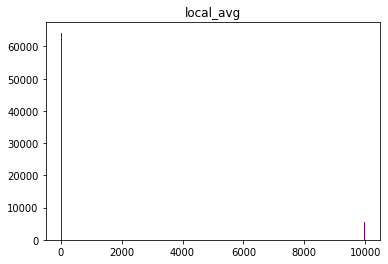

In [73]:
# Histogram for 'local_avg' response time (local) column
df1.hist(column='local_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['local_avg'].describe()

count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64

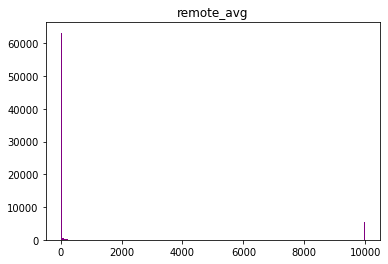

In [74]:
# Histogram for 'remote_avg' response time (local) column
df1.hist(column='remote_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['remote_avg'].describe()

Analysis: The histogram tells us that the the response time (ms) is estimated largely between 0 to 2,000 while there is a fewer amount at closer to 10,000 frequency for the response time between 8,000 to 10,000

In [98]:
# Duplicate the dataframe in case of crashes
df2 = df1.copy()

In [99]:
# map the local_delay and remote_delay to integers since that is what is needed by the classifier
df2['remote_delay_int'] = df2['remote_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
print(df2['remote_delay_int'].unique())
X = df2.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'remote_delay', 'hour'], axis = 1)
y = df2['hour']
print(X.head())
print(y.head())

[2]
   gr1000  gr750  gr500  gr410  gr190  gr100  gr75  gr0  remote_delay_int
0       0      0      0      0      0      0     0    1                 2
1       0      0      0      0      0      0     0    1                 2
2       0      0      0      0      0      0     0    1                 2
3       0      0      0      0      0      0     0    1                 2
4       0      0      0      0      0      0     0    1                 2
0    1
1    1
2    1
3    1
4    1
Name: hour, dtype: int32


In [100]:
# split out the test and train datasets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=99)
print(X_train, y_train)

       gr1000  gr750  gr500  gr410  gr190  gr100  gr75  gr0  remote_delay_int
33973       0      0      0      0      0      0     0    1                 2
68346       0      0      0      0      0      0     0    1                 2
18644       0      0      0      0      0      0     0    1                 2
11347       0      0      0      0      0      0     0    1                 2
59206       0      0      0      0      0      0     0    1                 2
...       ...    ...    ...    ...    ...    ...   ...  ...               ...
57042       0      0      0      0      0      0     0    1                 2
36008       0      0      0      0      0      0     0    1                 2
46265       0      0      0      0      0      0     0    1                 2
23587       0      0      0      0      0      0     0    1                 2
29313       0      0      0      0      0      0     0    1                 2

[55796 rows x 9 columns] 33973    0
68346    2
18644    1
11347

### Use scikit-learn for Logistic Regression and DecisionTree Classification, XGBoost, Keras, Pytorch to train, test and predict a categorical variable. Use appropriate metric and interpret themeaning of the score

### Logistic Regression

In [78]:
LogReg = LogisticRegression()

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_test)

In [79]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1 2]
Intercept [-0.02289705 -0.01942434  0.04232139]
Coefficients [[ 0.0907466  -0.0142235   0.00678151  0.00095779  0.02361307  0.01128548
   0.         -0.09392198  0.        ]
 [-0.06924005 -0.01188108 -0.01332728  0.00306959  0.00590847  0.00980965
   0.          0.0627188   0.        ]
 [-0.02150655  0.02610458  0.00654577 -0.00402738 -0.02952154 -0.02109513
   0.          0.03120317  0.        ]]


In [80]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.37020574951609436
              precision    recall  f1-score   support

           0       0.53      0.15      0.23      4610
           1       0.00      0.00      0.00      4525
           2       0.35      0.93      0.51      4814

    accuracy                           0.37     13949
   macro avg       0.29      0.36      0.25     13949
weighted avg       0.30      0.37      0.25     13949



C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318

### Decision Tree
- Done by Viphu Nguyen and Eric Topmiller

In [81]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=99)

In [82]:
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.37020574951609436

##### Plot a Decision Tree

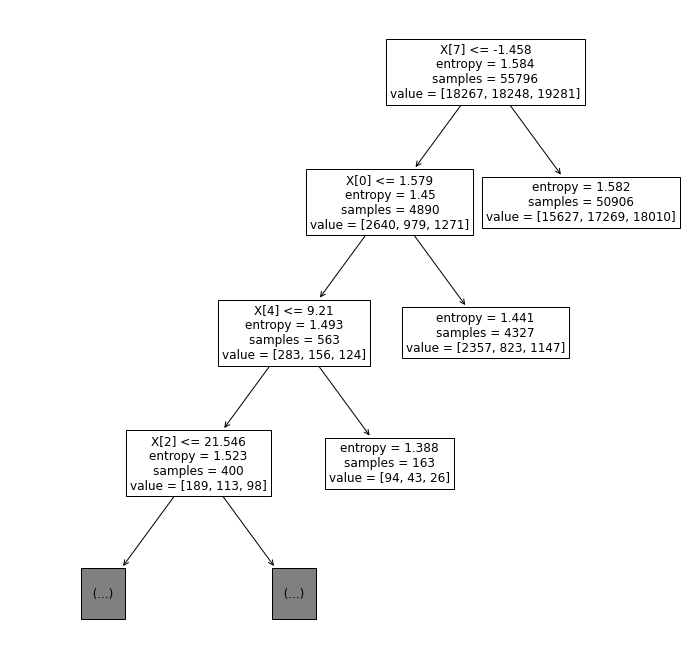

In [83]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 3,fontsize=12);

###  Show feature importance in XGBoost by using xgb.plot.importance

In [84]:
# !pip install xgboost
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, n_estimators=100, seed=99) 
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.370206


## Keras
### model from https://www.kaggle.com/code/nitinsss/time-series-prediction-with-keras-for-beginners/notebook

In [85]:
# uninstall existing tensorflow-macos and tensorflow-metal
# !pip uninstall tensorflow-macos
# !pip uninstall tensorflow-metal
# !pip install tensorflow-macos
# !pip install tensorflow-metal
# # Upgrade tensorflow-deps
# !pip install tensorflow-deps --force-reinstall
# # or point to specific conda environment
# #conda install -c apple tensorflow-deps --force-reinstall -n my_env 
# !pip install tensorflow

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# create the model input layers
input_layer = Input(shape=(9), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_6 (Dense)             (None, 60)                600       
                                                                 
 dense_7 (Dense)             (None, 60)                3660      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 61        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Make the dataframe like the kaggle example
df3 = df2.copy()
df3.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'remote_delay'], axis = 1, inplace=True)
df3.head()
df_new = df3.copy()

In [ ]:
# create the training, validation, and test inputs
df_copy = df3.copy()
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (62944, 9) (62944,)
Shape of validation inputs, validation target: (3313, 9) (3313,)
Shape of test inputs, test target: (3488, 9) (3488,)


In [ ]:
# We will normalize our data in the range in the range (0.01, 0.99) before feeding it to the the neural network.
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [ ]:
# training and validation
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/30
12589/12589 [==============================] - 13s 990us/step - loss: 0.1659 - val_loss: 0.2378
Epoch 2/30
12589/12589 [==============================] - 12s 944us/step - loss: 0.1633 - val_loss: 0.2456
Epoch 3/30
12589/12589 [==============================] - 12s 914us/step - loss: 0.1627 - val_loss: 0.2359
Epoch 4/30
12589/12589 [==============================] - 11s 912us/step - loss: 0.1628 - val_loss: 0.2363
Epoch 5/30
12589/12589 [==============================] - 12s 915us/step - loss: 0.1626 - val_loss: 0.2412
Epoch 6/30
12589/12589 [==============================] - 12s 917us/step - loss: 0.1627 - val_loss: 0.2396
Epoch 7/30
12589/12589 [==============================] - 11s 906us/step - loss: 0.1626 - val_loss: 0.2374
Epoch 8/30
12589/12589 [==============================] - 12s 923us/step - loss: 0.1626 - val_loss: 0.2380
Epoch 9/30
12589/12589 [==============================] - 12s 967us/step - loss: 0.1627 - val_loss: 0.2392
Epoch 10/30
12589/12589 [============

In [ ]:
# do the prediction
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [ ]:
# find the R2 score
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: -0.4313


In [ ]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual 8 hour period'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted 8 hour period'])

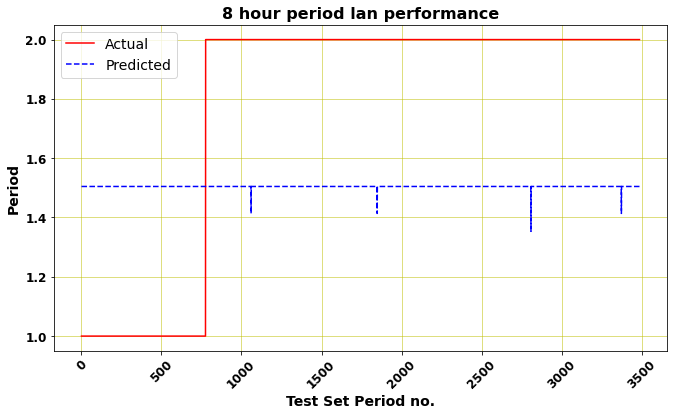

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('8 hour period lan performance', weight='bold', fontsize=16)
plt.ylabel('Period', weight='bold', fontsize=14)
plt.xlabel('Test Set Period no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

## Pytorch on Neural Network

In [101]:
# importing pytorch libraries
# !pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



In [102]:
df4 = df2.copy()
df4

,index,timestamp,source,local_avg,remote_avg,hour,remote_delay,gr1000,gr750,gr500,gr410,gr190,gr100,gr75,gr0,remote_delay_int
0,0,1.559041e+09,ethernet,0.19,8.14,1,Large,0,0,0,0,0,0,0,1,2
1,1,1.559041e+09,ethernet,0.15,7.75,1,Large,0,0,0,0,0,0,0,1,2
2,2,1.559041e+09,ethernet,0.15,8.68,1,Large,0,0,0,0,0,0,0,1,2
3,3,1.559041e+09,ethernet,0.15,8.08,1,Large,0,0,0,0,0,0,0,1,2
4,4,1.559041e+09,ethernet,0.15,8.20,1,Large,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69740,69740,1.559691e+09,ethernet,0.15,8.70,2,Large,0,0,0,0,0,0,0,1,2
69741,69741,1.559691e+09,ethernet,0.15,8.43,2,Large,0,0,0,0,0,0,0,1,2
69742,69742,1.559691e+09,ethernet,0.15,8.71,2,Large,0,0,0,0,0,0,0,1,2
69743,69743,1.559691e+09,ethernet,0.15,8.42,2,Large,0,0,0,0,0,0,0,1,2


In [103]:
cols = ['local_avg', 'remote_avg', 'remote_delay']
df4 = df4[cols]
df4

,local_avg,remote_avg,remote_delay
0,0.19,8.14,Large
1,0.15,7.75,Large
2,0.15,8.68,Large
3,0.15,8.08,Large
4,0.15,8.20,Large
...,...,...,...
69740,0.15,8.70,Large
69741,0.15,8.43,Large
69742,0.15,8.71,Large
69743,0.15,8.42,Large


In [104]:
# Converting the small, medium, and large to [0, 1, 2]
df4['remote_delay'].replace({'Small': 0, 'Medium': 1, 'Large': 2}, inplace = True)

C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


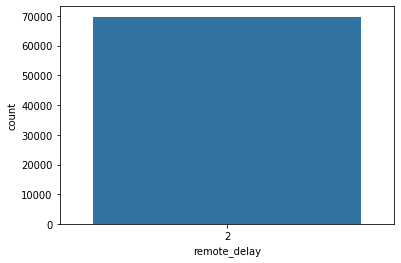

In [105]:
# To display the histogram of how often the response time is for the local delay input network 
sns.countplot(df4.remote_delay);

In [106]:
# To look at the percentage of how much impact is the response time for local delay 
df4.remote_delay.value_counts() / df4.shape[0]

2    1.0
Name: remote_delay, dtype: float64

In [107]:
# To split the data into train and test sets:
X = df4[['local_avg', 'remote_avg']]
y = df4[['remote_avg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# DEBUG #
print('x_train:' , X_train)
# print('x_test:', X_test)
# print('y_train:', y_train)
# print('y_test:', y_test)

x_train:        local_avg  remote_avg
60266     0.1500      8.3900
57072     0.1500      8.7700
51794  9999.9999   9999.9999
42041     0.1500      8.5100
10883     0.1600      8.5800
...          ...         ...
37194     0.1500      8.9300
6265      0.1500      9.3500
54886     0.1500      8.0000
860       0.1500      8.5700
15795     0.1700      8.4500

[55796 rows x 2 columns]


In [109]:
# Convert all of it to Tensors (so we can use it with PyTorch)
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([55796, 2]) torch.Size([55796])
torch.Size([13949, 2]) torch.Size([13949])


### Building a Neural Network

In [111]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
net

Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

In [112]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [113]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)


In [114]:
net = net.to(device)

criterion = criterion.to(device)

In [115]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(f'''epoch {epoch} Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0 Train set - loss: -117.484, accuracy: 0.0
            Test  set - loss: -115.523, accuracy: 0.0
            
epoch 100 Train set - loss: -78495.891, accuracy: 0.0
            Test  set - loss: -77152.258, accuracy: 0.0
            
epoch 200 Train set - loss: -78496.297, accuracy: 0.0
            Test  set - loss: -77152.719, accuracy: 0.0
            
epoch 300 Train set - loss: -78496.852, accuracy: 0.0
            Test  set - loss: -77153.312, accuracy: 0.0
            
epoch 400 Train set - loss: -78497.523, accuracy: 0.0
            Test  set - loss: -77154.055, accuracy: 0.0
            
epoch 500 Train set - loss: -78498.32, accuracy: 0.0
            Test  set - loss: -77154.938, accuracy: 0.0
            
epoch 600 Train set - loss: -78499.227, accuracy: 0.0
            Test  set - loss: -77155.961, accuracy: 0.0
            
epoch 700 Train set - loss: -78500.273, accuracy: 0.0
            Test  set - loss: -77157.125, accuracy: 0.0
            
epoch 800 Train set - l

### Compare the results of the algorithms (comparison, conclusion, challenges...etc.)

### Outcome of our analysis